Imports

In [95]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import List, Callable, Dict
from sklearn.preprocessing import LabelEncoder

import re
from functools import reduce
import nltk
from nltk.corpus import stopwords

from collections import OrderedDict
import gensim
import gensim.downloader as gloader

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from functools import partial
from sklearn.metrics import classification_report

Data pre-processing

In [96]:
#load data
trainData = pd.read_csv('./fever_data/train_pairs.csv')
testData = pd.read_csv('./fever_data/test_pairs.csv')
valData = pd.read_csv('./fever_data/val_pairs.csv')

#drop first column
trainData = trainData.drop(trainData.columns[0], axis=1)
valData = valData.drop(valData.columns[0], axis=1)
testData = testData.drop(testData.columns[0], axis=1)

#transfer label into 0/1,SUPPORTS-1,REFUTES-0
labelencoder = LabelEncoder()
labelencoder.fit(trainData['Label'])
trainData['Label'] =labelencoder.transform(trainData['Label'])
valData['Label'] =labelencoder.transform(valData['Label'])
testData['Label'] =labelencoder.transform(testData['Label'])

print("Training data size: {}".format(trainData.shape))
print("Test data size: {}".format(testData.shape))
print("Validation data size: {}".format(valData.shape))
print("Classes distribution:\n{}".format(trainData.Label.value_counts())) 

print("Some train examples: {}".format(trainData.iloc[:3]))
print("Some test examples: {}".format(testData.iloc[:3]))
print("Some validation examples: {}".format(valData.iloc[:3]))


Training data size: (121740, 4)
Test data size: (7189, 4)
Validation data size: (7165, 4)
Classes distribution:
1    89389
0    32351
Name: Label, dtype: int64
Some train examples:                                             Claim  \
0  Chris Hemsworth appeared in A Perfect Getaway.   
1                         Roald Dahl is a writer.   
2                       Roald Dahl is a governor.   

                                            Evidence  ID  Label  
0  2\tHemsworth has also appeared in the science ...   3      1  
1  0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...   7      1  
2  0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...   8      0  
Some test examples:                                                Claim  \
0    Anxiety has been linked with physical symptoms.   
1                         Firefox is an application.   
2  Keegan-Michael Key played President Barack Oba...   

                                            Evidence     ID  Label  
0  13\tFurthermore , anxiety

Text cleaning

In [97]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.:`\-\'\"]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-zA-Z #+_]')
#for example: -LSB- eˈlaða -RSB-
REMOVE_SB = re.compile('-LSB-(.*?)-RSB-')
REMOVE_RB = re.compile('-LRB-|-RRB-')
# for example: -LRB- 1944 -RRB-
RB_PAIRS = re.compile('-LRB-(.*?)-RRB-') 


try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub(' ', text)

def replace_br(text: str) -> str:
    """
    Replaces br characters
    """

    return text.replace(' br ', '')

def remove_SB_text(text):
    """
    Removes -LSB- and -RSB- pairs in the text
    """
    return REMOVE_SB.sub('', text)

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_RB_text(text):
    """
    Removes -LRB- -RRB- or -LRB- -RRB- pairs in the text
    """
    sentences = re.findall(RB_PAIRS, text)
    for sent in sentences: 
        if re.search(GOOD_SYMBOLS_RE, sent) is not None:
            text = RB_PAIRS.sub('', text, 1)
        else:
            text = REMOVE_RB.sub('', text, 2)
    return text


def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])


def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip()

def split_text(text: str) -> str:
    return text.split()


PREPROCESSING_PIPELINE = [
                          remove_SB_text,
                          remove_RB_text,
                          replace_special_characters,
                          replace_br,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          lower,
                          strip_text,
                          split_text
                          ]


def text_prepare(text: str,filter_methods=PREPROCESSING_PIPELINE):
    return reduce(lambda x, f: f(x), filter_methods, text)

print('Pre-processing text...')
print('Before:\n{}'.format(trainData[:3]))

# Replace each sentence with its pre-processed version
trainData.Claim = trainData.Claim.apply(lambda x: text_prepare(x))
#forexample: remove \t in '2\tHemsworth has also appeared'
trainData.Evidence = trainData.Evidence.apply(lambda x: x.split('\t')[1])
trainData.Evidence = trainData.Evidence.apply(lambda x: text_prepare(x))

testData.Claim = testData.Claim.apply(lambda x: text_prepare(x))
testData.Evidence = testData.Evidence.apply(lambda x: x.split('\t')[1])
testData.Evidence = testData.Evidence.apply(lambda x: text_prepare(x))

valData.Claim = valData.Claim.apply(lambda x: text_prepare(x))
valData.Evidence = valData.Evidence.apply(lambda x: x.split('\t')[1])
valData.Evidence = valData.Evidence.apply(lambda x: text_prepare(x))


print('After:\n{}'.format(trainData[:3]))
print("Pre-processing completed!")

Pre-processing text...
Before:
                                            Claim  \
0  Chris Hemsworth appeared in A Perfect Getaway.   
1                         Roald Dahl is a writer.   
2                       Roald Dahl is a governor.   

                                            Evidence  ID  Label  
0  2\tHemsworth has also appeared in the science ...   3      1  
1  0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...   7      1  
2  0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...   8      0  
After:
                                               Claim  \
0  [chris, hemsworth, appeared, a, perfect, getaway]   
1                              [roald, dahl, writer]   
2                            [roald, dahl, governor]   

                                            Evidence  ID  Label  
0  [hemsworth, also, appeared, science, fiction, ...   3      1  
1  [roald, dahl, british, novelist, short, story,...   7      1  
2  [roald, dahl, british, novelist, short, story,...   8      

Split the data

In [98]:
x_train_Claim = trainData.Claim.values
x_train_Evidence = trainData.Evidence.values
y_train = trainData.Label.values
x_test_Claim = testData.Claim.values
x_test_Evidence = testData.Evidence.values
y_test = testData.Label.values
x_val_Claim = valData.Claim.values
x_val_Evidence = valData.Evidence.values
y_val = valData.Label.values

print('Train claim data: ', x_train_Claim.shape)
print('Train evidence data: ', x_train_Evidence.shape)
print('Train label: ', y_train.shape)
print('Validation claim data: ', x_val_Claim.shape)
print('Validation evidence data: ', x_val_Evidence.shape)
print('Validation label: ', y_val.shape)
print('Test claim data: ', x_test_Claim.shape)
print('Test evidence data: ', x_test_Evidence.shape)
print('Test label: ', y_test.shape)


Train claim data:  (121740,)
Train evidence data:  (121740,)
Train label:  (121740,)
Validation claim data:  (7165,)
Validation evidence data:  (7165,)
Validation label:  (7165,)
Test claim data:  (7189,)
Test evidence data:  (7189,)
Test label:  (7189,)


Vocabulary creation

In [99]:
# Function definition
def build_vocabulary(df: pd.DataFrame) -> (Dict[int, str],Dict[str, int],List[str]):

    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()
    curr_idx = 0
    
    for sentence in tqdm(df.values):
        tokens = sentence
        for token in tokens:
          if token not in word_to_idx:
              word_to_idx[token] = curr_idx
              idx_to_word[curr_idx] = token
              curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

corpus = pd.concat([trainData.Claim,trainData.Evidence,valData.Claim,valData.Evidence],ignore_index=True)
idx_to_word, word_to_idx, word_listing = build_vocabulary(corpus)

print('Index -> Word vocabulary size: {}'.format(len(idx_to_word)))
print('Word -> Index vocabulary size: {}'.format(len(word_to_idx)))
print('The corpus length: {}'.format(len(word_listing)))
print('Some words: {}'.format([(idx_to_word[idx], idx) for idx in np.arange(10) + 1]))


100%|██████████| 257810/257810 [00:00<00:00, 997365.33it/s] 

Index -> Word vocabulary size: 31448
Word -> Index vocabulary size: 31448
The corpus length: 31448
Some words: [('hemsworth', 1), ('appeared', 2), ('a', 3), ('perfect', 4), ('getaway', 5), ('roald', 6), ('dahl', 7), ('writer', 8), ('governor', 9), ('ireland', 10)]


Downloading the embedding model

In [100]:
#download the glove
embedding_dimension = 50
download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

try:
    embedding_model = gloader.load(download_path)
except ValueError as e:
    print("Invalid embedding model name! Check the embedding dimension:")
    print("Glove: 50, 100, 200, 300")
    raise e


In [101]:
# check oov terms 
def check_OOV_terms(embedding_model,word_listing):
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

oov_terms = check_OOV_terms(embedding_model, word_listing)
print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_terms), float(len(oov_terms)) / len(word_listing)*100))

Total OOV terms: 1949 (6.20%)


In [102]:
from tensorflow.keras.preprocessing.text import Tokenizer
oov_token = "<OOV>"
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(corpus)

vocabLength = len(tokenizer.word_index)+1 
print("Tokenizer vocabulary length: {}".format(vocabLength))

Tokenizer vocabulary length: 31450


Bulid the embedding matrix

In [103]:
# Function definition

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int]) -> np.ndarray:

    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_dimension))
    for word, i in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[i] = embedding_vector

    return embedding_matrix


embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index)

print("Embedding matrix shape: {}".format(embedding_matrix.shape))

100%|██████████| 31449/31449 [00:00<00:00, 495234.38it/s]

Embedding matrix shape: (31450, 50)


Data Convertion

In [104]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def convert_text(texts, tokenizer,max_seq_length):

    text_ids = tokenizer.texts_to_sequences(texts)
    text_ids = pad_sequences(text_ids, padding='post', truncating='post', maxlen=max_seq_length,dtype='float32')
    # text_ids = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids]
    # text_ids = np.array([seq[:max_seq_length] for seq in text_ids])

    return text_ids

max_seq_length = max(len(x) for x in corpus)
print("Max sentence length is: {} words".format(max_seq_length))

# Train
x_train_Claim = convert_text(x_train_Claim, tokenizer,max_seq_length)
x_train_Evidence = convert_text(x_train_Evidence, tokenizer,max_seq_length)

print(x_train_Claim[:3])
print('X claim train shape: ', x_train_Claim.shape)
print('X evidence train shape: ', x_train_Evidence.shape)
print('Y train shape: ', y_train.shape)

# Val
x_val_Claim = convert_text(x_val_Claim, tokenizer,max_seq_length)
x_val_Evidence = convert_text(x_val_Evidence, tokenizer,max_seq_length)
print('X claim val shape: ', x_val_Claim.shape)
print('X evidence val shape: ', x_val_Evidence.shape)
print('Y val shape: ', y_val.shape)

# Test
x_test_Claim = convert_text(x_test_Claim, tokenizer,max_seq_length)
x_test_Evidence = convert_text(x_test_Evidence, tokenizer,max_seq_length)
print('X claim test shape: ', x_test_Claim.shape)
print('X evidence test shape: ', x_test_Evidence.shape)
print('Y test shape: ', y_test.shape)

Max sentence length is: 91 words
[[ 267. 2253.   68.   26.  975. 5565.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.]
 [5190. 4133.   99.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.   

In [105]:
from tensorflow.keras import backend as K

#Cosine similarity
def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)


# merging strategy and Concatenate cosine similarity to the result
def merge_multi_inputs(strategy,input1,input2):

  distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([input1, input2])
  merge = []
  if strategy == 'concatenation':
    merge = Concatenate()([input1, input2])
  elif strategy == 'sum':
    merge = Add()([input1, input2])
  elif strategy == 'mean':
    merge = Average()([input1, input2])
  #concatenate cosine similarity with the claim and evidence
  merge = Concatenate()([merge, distance])
  return merge



Model Definition

Lstm: take the last state as the sentence embedding

In [106]:
def create_lstm_model1(merging_stragegy : str,compile_info: Dict) -> keras.Model:

    #input layer
    claimInput=Input(shape=(max_seq_length,))
    embedding_layer_claim = Embedding(input_dim = vocabLength,
                                output_dim = embedding_dimension,
                                weights= [embedding_matrix],
                                input_length=max_seq_length,
                                mask_zero = True,
                                name = "embedding_layer_claim")(claimInput)
    eviInput=Input(shape=(max_seq_length,))
    embedding_layer_evi = Embedding(input_dim = vocabLength,
                                output_dim = embedding_dimension,
                                weights=[embedding_matrix],
                                input_length=max_seq_length,
                                mask_zero = True,
                                name = "embedding_layer_evi")(eviInput)
    #lstm layer
    Lstm_layer_claim = Bidirectional(LSTM(64))(embedding_layer_claim)
    Lstm_layer_evi = Bidirectional(LSTM(64))(embedding_layer_evi)

    # merge claim + evidence + cosine similarity
    merge_data = merge_multi_inputs(merging_stragegy,Lstm_layer_claim,Lstm_layer_evi)
   
    dense_output1 = Dense(units = 256, activation = "relu", name="dense_1")(merge_data)
    dense_output2 = Dense(units = 64, activation = "relu", name="dense_2")(dense_output1)
    dropout_output = Dropout(0.2)(dense_output2) #overfitting
    last_output = Dense(units = 1, activation = "sigmoid", name="logits")(dropout_output)

    model = Model(inputs=[claimInput,eviInput], outputs=last_output)  
    model.summary()
    model.compile(**compile_info)

    return model

Lstm: average all the output states.

In [107]:
def create_lstm_model2(merging_stragegy : str,compile_info: Dict) -> keras.Model:

    #input layer  
    claimInput=Input(shape=(max_seq_length,))
    embedding_layer_claim = Embedding(input_dim = vocabLength,
                                output_dim = embedding_dimension,
                                weights= [embedding_matrix],
                                input_length=max_seq_length,
                                mask_zero = True,
                                name = "embedding_layer_claim")(claimInput)
    eviInput=Input(shape=(max_seq_length,))
    embedding_layer_evi = Embedding(input_dim = vocabLength,
                                output_dim = embedding_dimension,
                                weights=[embedding_matrix],
                                input_length=max_seq_length,
                                mask_zero = True,
                                name = "embedding_layer_evi")(eviInput)
    #lstm layer
    #return_sequence=True output shape:3d / return_sequence=flase output shape:2d
    Lstm_layer_claim = Bidirectional(LSTM(64,return_sequences=True))(embedding_layer_claim)
    Lstm_layer_evi = Bidirectional(LSTM(64,return_sequences=True))(embedding_layer_evi)
    #average the output
    average_claim = GlobalAveragePooling1D()(Lstm_layer_claim)
    average_evi = GlobalAveragePooling1D()(Lstm_layer_evi)
    # merge claim + evidence + cosine similarity
    merge_data = merge_multi_inputs(merging_stragegy,average_claim,average_evi)
    dense_output1 = Dense(units = 256, activation = "relu", name="dense_1")(merge_data)
    dense_output2 = Dense(units = 64, activation = "relu", name="dense_2")(dense_output1)
    dropout_output = Dropout(0.2)(dense_output2)
    last_output = Dense(units = 1, activation = "sigmoid", name="logits")(dropout_output)

    model = Model(inputs=[claimInput,eviInput], outputs=last_output)
    model.summary()
    model.compile(**compile_info)

    return model

MLP：reshape the 3D input to 2D

In [108]:
def create_mlp_model(merging_stragegy : str,compile_info: Dict) -> keras.Model:

    # input layer
    claimInput=Input(shape=(max_seq_length,))
    embedding_layer_claim = Embedding(input_dim = vocabLength,
                                output_dim = embedding_dimension,
                                weights= [embedding_matrix],
                                input_length=max_seq_length,
                                mask_zero = True,
                                name = "embedding_layer_claim")(claimInput)
    eviInput=Input(shape=(max_seq_length,))
    embedding_layer_evi = Embedding(input_dim = vocabLength,
                                output_dim = embedding_dimension,
                                weights=[embedding_matrix],
                                input_length=max_seq_length,
                                mask_zero = True,
                                name = "embedding_layer_evi")(eviInput)
    # reshape the 3D input from `[batch_size, max_tokens, embedding_dim]` to `[batch_size, max_tokens * embedding_dim]`
    reshape_claim = Reshape((embedding_layer_claim.shape[2] * embedding_layer_claim.shape[1],))(embedding_layer_claim)
    reshape_evi = Reshape((embedding_layer_evi.shape[2] * embedding_layer_evi.shape[1],))(embedding_layer_evi)
    # merge claim + evidence + cosine similarity 
    merge_data = merge_multi_inputs(merging_stragegy,reshape_claim,reshape_evi)
    dense_output1 = Dense(units = 256, activation = "relu", name="dense_1")(merge_data)
    dense_output2 = Dense(units = 64, activation = "relu", name="dense_2")(dense_output1)
    dropout_output = Dropout(0.2)(dense_output2)
    last_output = Dense(units = 1, activation = "sigmoid", name="logits")(dropout_output)

    model = Model(inputs=[claimInput,eviInput], outputs=last_output)
    model.summary()
    model.compile(**compile_info)

    return model

BOV:Compute the sentence embedding as the mean of its token embeddings

In [109]:
def create_bov_model(merging_stragegy : str,compile_info: Dict) -> keras.Model:

    #input layer
    claimInput=Input(shape=(max_seq_length,))
    embedding_layer_claim = Embedding(input_dim = vocabLength,
                                output_dim = embedding_dimension,
                                weights= [embedding_matrix],
                                input_length=max_seq_length,
                                mask_zero = True,
                                name = "embedding_layer_claim")(claimInput)
    eviInput=Input(shape=(max_seq_length,))
    embedding_layer_evi = Embedding(input_dim = vocabLength,
                                output_dim = embedding_dimension,
                                weights=[embedding_matrix],
                                input_length=max_seq_length,
                                mask_zero = True,
                                name = "embedding_layer_evi")(eviInput)
    # compute the mean
    average_claim = GlobalAveragePooling1D()(embedding_layer_claim)
    average_evi = GlobalAveragePooling1D()(embedding_layer_evi)
    # merge claim + evidence + cosine similarity
    merge_data = merge_multi_inputs(merging_stragegy,average_claim,average_evi)
   
    dense_output1 = Dense(units = 256, activation = "relu", name="dense_1")(merge_data)
    dense_output2 = Dense(units = 64, activation = "relu", name="dense_2")(dense_output1)
    dropout_output = Dropout(0.2)(dense_output2)
    last_output = Dense(units = 1, activation = "sigmoid", name="logits")(dropout_output)

    model = Model(inputs=[claimInput,eviInput], outputs=last_output)
    model.summary()
    model.compile(**compile_info)

    return model

In [110]:
merging_strategy = [
    'concatenation', 
    'sum',
    'mean'
]

compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-3),
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy'],
}



In [111]:
# plot the accuracy and loss
def show_history(history: keras.callbacks.History):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    #accuracy image
    plt.plot(epochs,acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc='lower right')
    plt.figure()

    #loss image
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def train_model(model: keras.Model,
                x_train_Claim: np.ndarray,
                x_train_Evidence: np.ndarray,
                y_train: np.ndarray,
                x_val_Claim: np.ndarray,
                x_val_Evidence: np.ndarray,
                y_val: np.ndarray,
                training_info: Dict):

    print("Start training! \nParameters: {}".format(training_info))
    history = model.fit(x=(x_train_Claim,x_train_Evidence), y=y_train,
                        validation_data=([x_val_Claim,x_val_Evidence], y_val),
                        **training_info)
    print("Training completed! Showing history...")

    show_history(history)

    return model

def predict_data(model: keras.Model,
                 x_test_Claim: np.ndarray,
                 x_test_Evidence:np.ndarray,
                 prediction_info: Dict) -> np.ndarray:

    print('Starting prediction: \n{}'.format(prediction_info))
    print('Predicting on {} samples'.format(x_test_Claim.shape[0]))

    predictions = model.predict([x_test_Claim,x_test_Evidence], **prediction_info)
    return predictions


def evaluate_predictions(predictions: np.ndarray,
                         y: np.ndarray,
                         metrics: List[Callable],
                         metric_names: List[str]):

    assert len(metrics) == len(metric_names)

    print("Evaluating predictions! Total samples: ", y.shape[0])

    metric_info = {}

    for metric, metric_name in zip(metrics, metric_names):
        metric_value = metric(y_pred=predictions, y_true=y)
        metric_info[metric_name] = metric_value

    return metric_info


# Training info
training_info = {
    'verbose': 1,
    'epochs': 30,
    'batch_size': 128,
    'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=10,
                                                restore_best_weights=True)]
}
# prediction info
prediction_info = {
    'batch_size': 128,
    'verbose': 1
}

# Evaluation info
metrics = [
    accuracy_score,
    partial(f1_score, pos_label=1, average='binary')
]
metric_names = [
    "accuracy",
    "binary_f1"
]

create_models={
    'lstm_model': create_lstm_model1,
    'lstm_model_withAverage': create_lstm_model2,
    'mlp_model': create_mlp_model,
    'bov_model':create_bov_model
}


Performance evaluation

Multi-input classification evaluation

In [112]:
def print_evaluation(testLable,testPrediction):
    report = classification_report(testLable, testPrediction,zero_division=True,labels=[0,1], target_names=["REFUTES", "SUPPORTS"])
    print(report)

Claim verification evaluation

In [113]:
import copy
def print_verifEvaluation(testPrediction):
    testDataCopy = copy.deepcopy(testData)
    testDataCopy.insert(4,'Prediction',testPrediction)
    rule = lambda x: x.mode().iat[0]
    voting_test_label = testDataCopy.groupby('ID')['Label'].apply(rule).reset_index(name='Majority_Label')
    voting_predict_label = testDataCopy.groupby('ID')['Prediction'].apply(rule).reset_index(name='Majority_Label')

    report = classification_report(voting_test_label['Majority_Label'], voting_predict_label['Majority_Label'],zero_division=True,labels=[0,1], target_names=["REFUTES", "SUPPORTS"])
    print(report)


Choose one model and try all merging strategies

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 91)]         0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 91)]         0           []                               
                                                                                                  
 embedding_layer_claim (Embeddi  (None, 91, 50)      1572500     ['input_23[0][0]']               
 ng)                                                                                              
                                                                                                  
 embedding_layer_evi (Embedding  (None, 91, 50)      1572500     ['input_24[0][0]']        

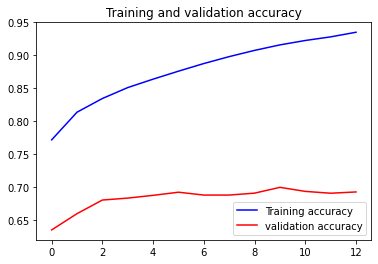

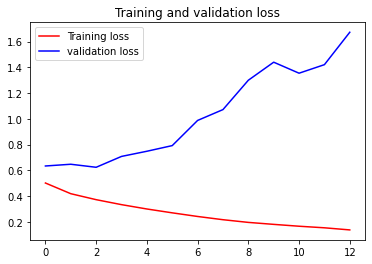

Starting prediction: 
{'batch_size': 128, 'verbose': 1}
Predicting on 7189 samples
57/57 [==============================] - 3s 11ms/step
Evaluating predictions! Total samples:  7189
Model: lstm_model, Merging Strategy:  concatenation 

Metrics info: 
{'accuracy': 0.6643483099179301, 'binary_f1': 0.7268817204301075}
Multi-input classification evaluation: 

              precision    recall  f1-score   support

     REFUTES

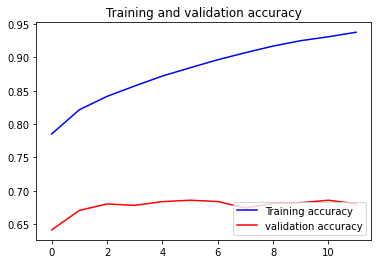

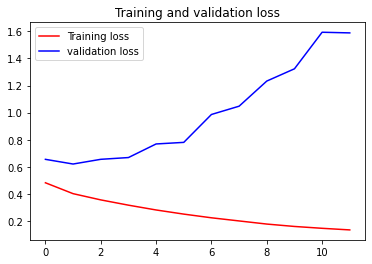

Starting prediction: 
{'batch_size': 128, 'verbose': 1}
Predicting on 7189 samples
57/57 [==============================] - 3s 11ms/step
Evaluating predictions! Total samples:  7189
Model: lstm_model, Merging Strategy:  sum 

Metrics info: 
{'accuracy': 0.6617053832243706, 'binary_f1': 0.7313300927971719}
Multi-input classification evaluation: 

              precision    recall  f1-score   support

     REFUTES       0.83      0.40      0.54      3583
    SUPPORTS    

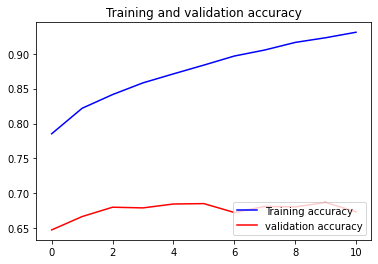

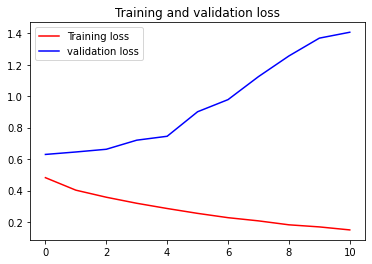

Starting prediction: 
{'batch_size': 128, 'verbose': 1}
Predicting on 7189 samples
57/57 [==============================] - 3s 12ms/step
Evaluating predictions! Total samples:  7189
Model: lstm_model, Merging Strategy:  mean 

Metrics info: 
{'accuracy': 0.6454305188482403, 'binary_f1': 0.7275836272309502}
Multi-input classification evaluation: 

              precision    recall  f1-score   support

     REFUTES       0.

In [114]:
for ms in merging_strategy:
    model = create_models["lstm_model"](ms, compile_info)
    model = train_model(model=model, x_train_Claim=x_train_Claim, x_train_Evidence=x_train_Evidence,y_train=y_train,
                    x_val_Claim=x_val_Claim,x_val_Evidence=x_val_Evidence, y_val=y_val, training_info=training_info)
    test_predictions = predict_data(model=model, x_test_Claim=x_test_Claim,x_test_Evidence=x_test_Evidence,
                                    prediction_info=prediction_info)
    test_predictions = np.round(test_predictions,0).astype(np.int32)
    metric_info = evaluate_predictions(predictions=test_predictions,
                                y=y_test,
                                metrics=metrics,
                                metric_names=metric_names)
    print("Model: lstm_model, Merging Strategy: ", ms, "\n")
    print('Metrics info: \n{}'.format(metric_info))
    print('Multi-input classification evaluation: \n')
    print_evaluation(y_test,test_predictions)
    print('Claim verification evaluation: \n')
    print_verifEvaluation(test_predictions)
    